In [1]:
from datetime import datetime;
today = datetime.today().strftime('%m-%d').replace('-',"").replace(' ',"")

In [2]:
threshold = 0.4

# map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7 ,7:8, 8:9,};
map_dict_train = {'other':0, 'Environment':0, 'alarm': 8,
                'en_help': 1, 'ch_help': 2, 'ja_help': 3, 'tw_help': 4, #'hk_help': 5, 'yue_help':6,
                'dog':5, 'cat':6, 'flush':7, 'glass_breaking_selected':9};

# map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6};

choose_class = [0,1,2,3,4,5,6,7,8,9]

pr_rate = 0.8

In [3]:
project_PATH = '/home/sail/sound_project/sound_ai_v4_4'
# step_now = 'STEP/step_1'
step_now = 'sys/step_1_base_model'

save_model_name = '10C_model_v4_4'

save_name = f'model_10C_v4_4_{today}_pr{pr_rate}_byChristine.cc'

Data_npz_path = f'/home/sail/sound_project/DATA/using_data_v4/data_v4_4.npz'

In [4]:
import os
print(os.getcwd())
import sys
sys.path.append(os.path.abspath(f'{project_PATH}/common'))

import utils as U
import opts as opts;
import calculator as calc;
import tlopts as tlopts
import agent_attention_pytorch as att

from config_utility import *

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

/home/sail/sound_project/sound_ai_v4_5/sys


In [5]:
import sys;
import os;
import glob;
import math;
import numpy as np;
import glob;
import random;
from collections import Counter 
import time;

import torch;
from torch.utils.data import  DataLoader
import torch.optim as optim;
import torch.nn as nn;
import torch.nn.functional as F
import json

import argparse
from itertools import repeat
import pathlib



In [6]:
sys.path.append(os.path.abspath(f'{project_PATH}/STEP/sys'))

from model import att_Model
from trainer import TLTrainer

In [7]:

data = np.load(Data_npz_path, allow_pickle=True) 
# audio_max_value =  float((data['sounds_train']).max()) # *2 # the max value of the sound samples
# audio_min_value =  float((data['sounds_train']).min()) # *2 # the max value of the sound samples
print("train",Counter(data['labels_train'].tolist()), "\n val",Counter(data['labels_val'].tolist()))
# audio_max_value, audio_min_value

train Counter({0: 7973, 5: 2068, 2: 1648, 4: 952, 6: 876, 7: 828, 8: 804, 1: 559, 9: 559, 3: 316}) 
 val Counter({0: 197, 6: 36, 5: 35, 2: 30, 4: 26, 7: 26, 1: 24, 9: 24, 3: 20, 8: 20})


In [8]:
# labels = data['labels_train'].tolist()
# samples = data['sounds_train'].tolist()

In [9]:
def genDataTimeStr():
    return datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace('-',"").replace(' ',"").replace(':',"");

def getDateStr():
    return datetime.today().strftime('%Y-%m-%d %H').replace('-',"").replace(' ',"")

In [10]:
def getOpts():
    parser = argparse.ArgumentParser(description='!NO! Transfer Learning and add attention');
    parser.add_argument('--netType', default='add_attention',  required=False);
    parser.add_argument('--BC', default=True, action='store_true', help='BC learning');
    # parser.add_argument('--data', default='../datasets/processed/',  required=False);
    parser.add_argument('--dataset', required=False, default='v4', choices=['10']);
    
    opt, _ = parser.parse_known_args(); #在ipynb中，不能使用parser.parse，要改用parser.parse_known_args()

    opt.project_PATH = project_PATH
    #Basic Net Settings
    opt.nClasses = len(choose_class) #
    opt.threshold = threshold
    opt.nFolds = 1; #
    opt.splits = [i for i in range(1, opt.nFolds + 1)];
    opt.sr = 16000;
    opt.inputLength = 16000;

    opt.Data_npz_path = Data_npz_path
    opt.classes_dict = map_dict_train
    # opt.audio_max_value = audio_max_value
    opt.other_class = 0
    opt.choose_or_not =  True
    opt.choose_class = choose_class
    
    #Leqarning settings
    opt.ch_confing_10 = 32
    opt.fcn_no_of_inputs = opt.nClasses
    opt.ch_n_class = opt.nClasses

    opt.batch_size =  128;
    opt.batchSize = opt.batch_size 
    # opt.lr = 0.01; # 0.1
    opt.lr = 0.1; # 0.1
    opt.weightDecay = 5e-4 #9e-3;#5e-3;#5e-2;#1e-2;#5e-4;
    opt.momentum = 0.9 # 0.9;
    # opt.nEpochs = 300; # 1600
    opt.nEpochs = 300; # 1600
    # opt.schedule = [0.03, 0.05, 0.09, 0.1];
    opt.schedule = [0.3, 0.5, 0.9];
    opt.warmup = 10;
    
    opt.least_save_epoch = 5;
    opt.first_save_acc = 75.0;
    opt.save_val_acc = 99.0;
    opt.save_train_acc = 90.0;


    if torch.backends.mps.is_available():
        opt.device="mps"; #for apple m2 gpu
    elif torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"

    print(f"***Use device:{opt.device}");

    #Test data
    opt.nCrops = 1;
    opt.TLAcdnetConfig = []

    return opt
    # opt = parser.parse_args();

In [11]:
def ChkAndCreateSingleDir(dir_path):
    if not pathlib.Path(dir_path).is_dir():
        os.mkdir(dir_path);
        print(f"'{dir_path}' folder is created.");

## step1

In [12]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
try:
    os.mkdir(f'{project_PATH}/{step_now}/save_pt_model_s1')
except FileExistsError:
    pass
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s1/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16' already exists.


In [13]:
logObj = None;
def main():
    global logObj;
    opt = getOpts()
    opt.best_save_name = None
    opt.trainStartTime = genDataTimeStr();
    opt.modelSaveDir = f'{save_pt_model_path}/base4C_train_lr{opt.lr}_bs{opt.batch_size}_wd{opt.weightDecay}_{opt.trainStartTime}/'

    if not pathlib.Path(opt.modelSaveDir).is_dir():
        os.makedirs(opt.modelSaveDir,exist_ok=True);
        print(f"'{opt.modelSaveDir}' is created.");
    tlopts.display_info(opt)
    opt.model_name = save_model_name+"hacc{:.4f}_valacc{:.4f}_hacctr{:.4f}_tracc{:.4f}_{}th_sum_{:.4f}.pt"
    ###
    logSaveDir = opt.modelSaveDir + "/base_training_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    opt.logName = "BaseTrainLog_{}.log".format(opt.trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,opt.logName),'w');

    print("Initializing TLTrainer Object.....")
    trainer = TLTrainer(opt)
    print("Start to training.....")
    model = trainer.Train();

    return opt.best_save_name

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/' is created.
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v4
| nEpochs  : 300
| LRInit   : 0.1
| batchSize: 128
| Momentum   : 0.9
| weightDecay: 0.0005
| schedule : [0.3, 0.5, 0.9]
| warmup   : 10
| nFolds: 1
| Splits: [1]
+------------------------------+
'/home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619//base_training_logs/' folder is created.
Initializing TLTrainer Object.....
Start to training.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
sfeb.0.weight:True
sfeb.1.weight:True
sfeb.1.bias:True
sfeb.3.weight:True
sfeb.4.weight:True
sfeb.4.bias:True
tfeb.0.weight:True
tfeb.1.weight:True
tfeb.1.bias:True
tfeb.4.weight:True
tfeb

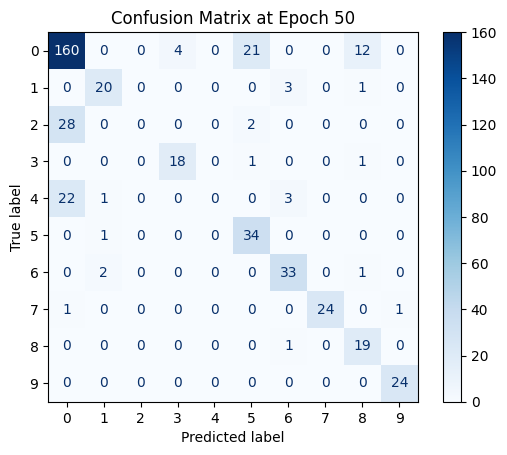

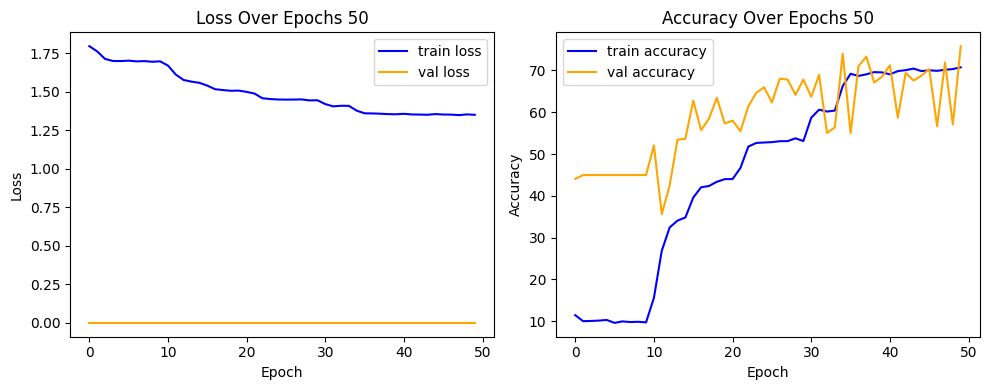

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc75.7991_valacc75.7991_hacctr0.0000_tracc70.1382_51th_sum_221.7364.pt
SP-[1] Epoch: 51/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.3520  Acc 70.14% | HA 0.00@0 | Val: Loss nan  Acc 75.80% | HA 75.80@51 | Sum 145.94 HA 75.80
SP-[1] Epoch: 52/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.3503  Acc 70.41% | HA 0.00@0 | Val: Loss nan  Acc 65.30% | HA 75.80@51 | Sum 135.71 HA 75.80
SP-[1] Epoch: 53/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.3480  Acc 70.31% | HA 0.00@0 | Val: Loss nan  Acc 73.74% | HA 75.80@51 | Sum 144.05 HA 75.80
SP-[1] Epoch: 54/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.3494  Acc 70.50% | HA 0.00@0 | Val: Loss nan  Acc 64.61% | HA 75.80@51 | Sum 135.11 HA 75.80
SP-[1] Epoch: 55/300 | Time: 0m40s (Train 0m40s  Val

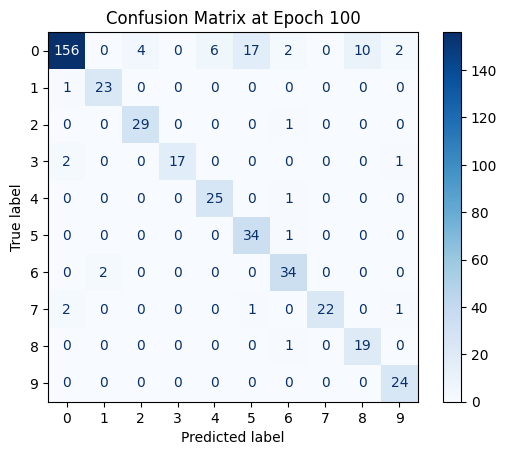

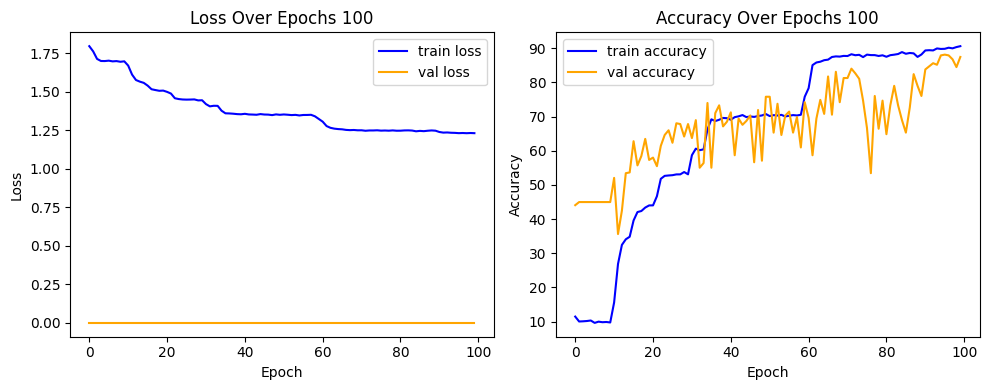

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc88.1279_valacc87.8995_hacctr90.8353_tracc90.8353_101th_sum_357.6981.pt
SP-[1] Epoch: 101/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2310  Acc 90.84% | HA 90.84@101 | Val: Loss nan  Acc 87.90% | HA 88.13@96 | Sum 178.73 HA 178.96
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc88.1279_valacc87.6712_hacctr90.8353_tracc90.5769_101th_sum_357.2113.pt
SP-[1] Epoch: 102/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2304  Acc 90.58% | HA 90.84@101 | Val: Loss nan  Acc 87.67% | HA 88.13@96 | Sum 178.25 HA 178.96
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_l

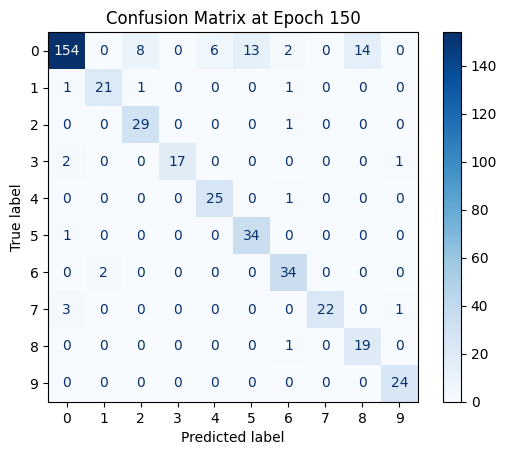

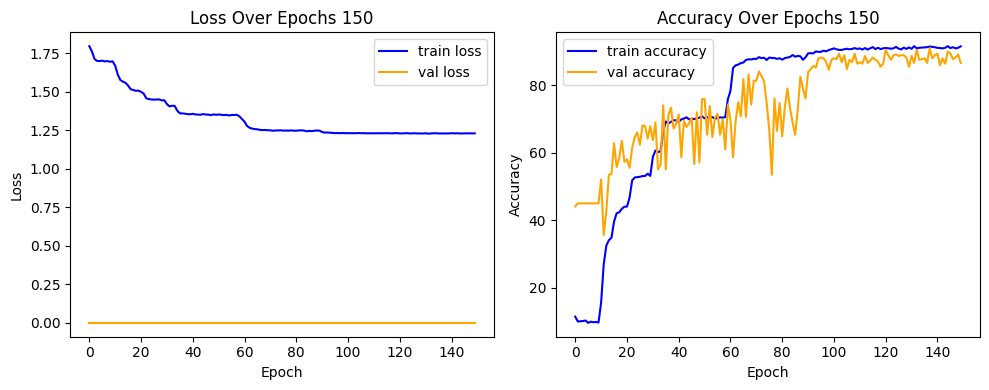

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc90.8676_valacc88.8128_hacctr91.4904_tracc91.0036_150th_sum_362.1743.pt
SP-[1] Epoch: 151/300 | Time: 0m39s (Train 0m39s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2273  Acc 91.00% | HA 91.49@145 | Val: Loss nan  Acc 88.81% | HA 90.87@138 | Sum 179.82 HA 182.36
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc90.8676_valacc88.1279_hacctr91.4904_tracc91.3462_151th_sum_361.8320.pt
SP-[1] Epoch: 152/300 | Time: 0m40s (Train 0m39s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2284  Acc 91.35% | HA 91.49@145 | Val: Loss nan  Acc 88.13% | HA 90.87@138 | Sum 179.47 HA 182.36
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_tra

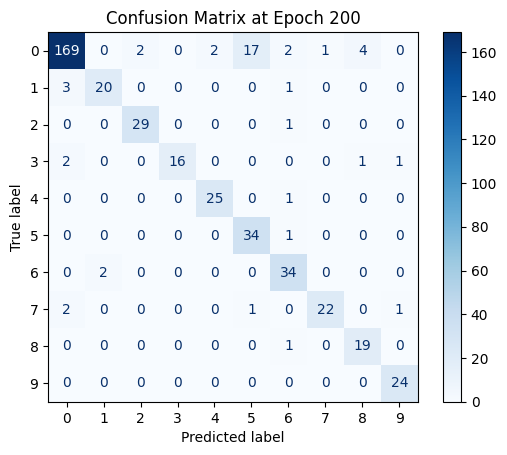

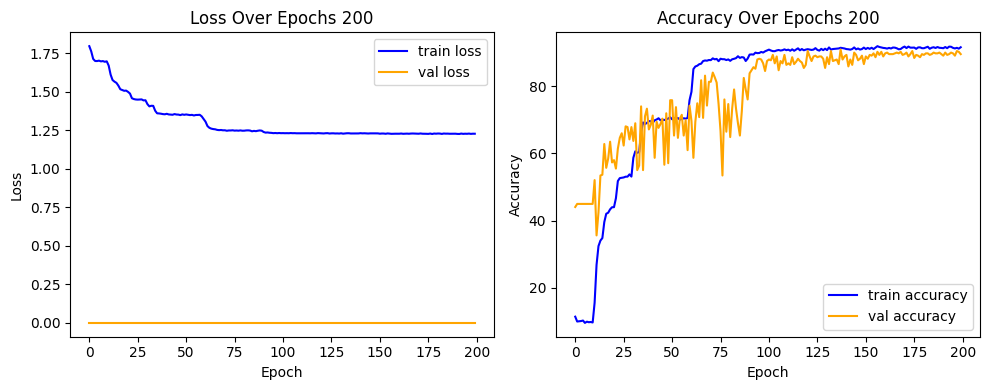

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc90.8676_valacc88.5845_hacctr91.8630_tracc91.1719_200th_sum_362.4869.pt
SP-[1] Epoch: 201/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2273  Acc 91.17% | HA 91.86@157 | Val: Loss nan  Acc 88.58% | HA 90.87@138 | Sum 179.76 HA 182.73
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc90.8676_valacc89.2694_hacctr91.8630_tracc91.3041_201th_sum_363.3041.pt
SP-[1] Epoch: 202/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2279  Acc 91.30% | HA 91.86@157 | Val: Loss nan  Acc 89.27% | HA 90.87@138 | Sum 180.57 HA 182.73
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_tra

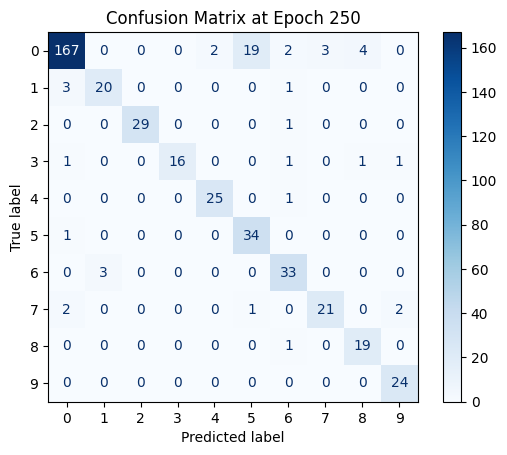

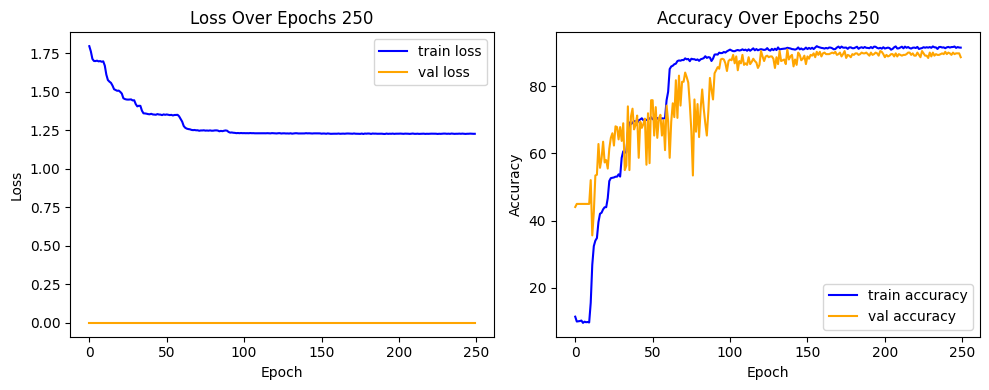

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc90.8676_valacc89.4977_hacctr91.8630_tracc91.2800_250th_sum_363.5083.pt
SP-[1] Epoch: 251/300 | Time: 0m39s (Train 0m39s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2276  Acc 91.28% | HA 91.86@157 | Val: Loss nan  Acc 89.50% | HA 90.87@138 | Sum 180.78 HA 182.73
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc90.8676_valacc88.5845_hacctr91.8630_tracc91.4002_251th_sum_362.7153.pt
SP-[1] Epoch: 252/300 | Time: 0m39s (Train 0m39s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2277  Acc 91.40% | HA 91.86@157 | Val: Loss nan  Acc 88.58% | HA 90.87@138 | Sum 179.98 HA 182.73
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_tra

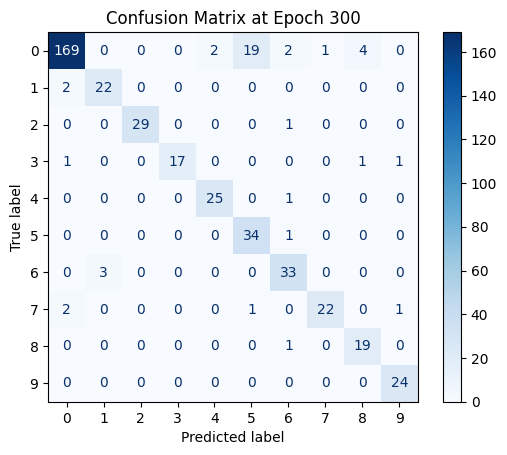

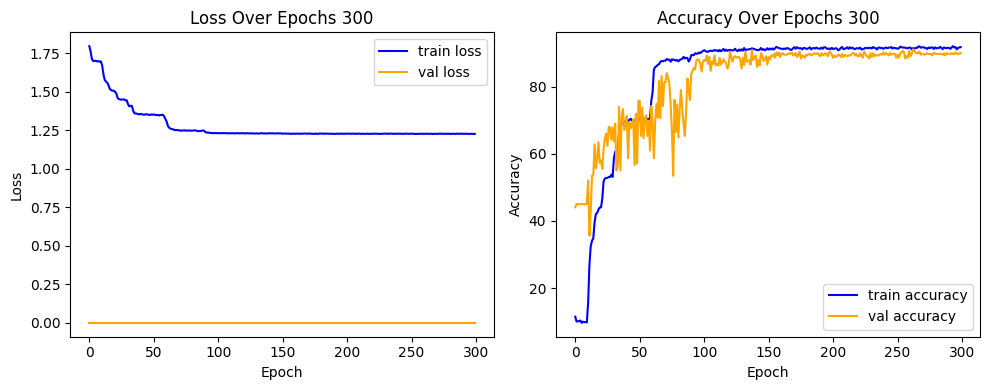

Execution finished in: 3h21m
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc91.0959_valacc89.9543_hacctr92.0433_tracc91.7488_299th_sum_364.8423.pt
365.527108999399


In [14]:
step_1_model_path = main()
# main()


In [15]:
step_1_model_path

'/home/sail/sound_project/sound_ai_v4_4/sys/step_1_base_model/save_pt_model_s1/20241212_16/base4C_train_lr0.1_bs128_wd0.0005_20241212163619/10C_model_v4_4hacc91.0959_valacc91.0959_hacctr91.8930_tracc91.4423_263th_sum_365.5271.pt'

## step 2

In [16]:
step_now = 'sys/step_2_pruning'

In [17]:
# step_1_model_path = '/home/sail/sound_project/sound_ai_v2.2.2/sys/step1_base_model/save_pt_model_s1/20241007_17/base4C_train_lr0.1_bs64_wd0.0005_20241007173709/9C_att_model_hacc100.0000_valacc99.1071_hacctr90.5093_tracc90.5093_298th_sum_380.1257.pt'

In [18]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s2'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/save_pt_model_s2' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19' created successfully.


In [19]:
from sparsify import PruningTrainer


In [20]:
def main():
    global logObj;
    opt = getOpts()
    opt.trainer = None

    # opt.nEpochs = 300;
    # opt.least_save_epoch = 50;
    # opt.first_save_acc = 75.0;
    # opt.save_val_acc = 95.0;
    opt.save_train_acc = 90.0;

    opt.prune_ratio = pr_rate
    opt.base_model_path = step_1_model_path
    trainStartTime = getDateStr();
    save_dir = f"{save_pt_model_path}/pruning_4C_time_{trainStartTime}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.save_dir = save_dir;
    opt.model_name = save_model_name+"_first_stage_prun_haacc_{:.4f}_valacc{:.4f}_tracc{:.4f}_epoch_{}.pt";
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt)#TLTrainer(opt)
    print("Start to pruning.....")
    logSaveDir = opt.save_dir+"/first_stage_pruning_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    logName = "FirstPruningLog_{}.log".format(trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,logName),'w');
    trainer.PruneAndTrain();
    opt.logObj.flush();
    opt.logObj.close();
    return opt.best_save_name

***Use device:cuda:0
Initializing PruneAndTrain Object.....
!!! In PruningTrainer:: current used device:cuda:0
Start to pruning.....
'/home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0//first_stage_pruning_logs/' folder is created.
cuda:0
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2     (16, 1, 7996)     (16, 1, 7996)         32            0
         ReLu-3     (16, 1, 7996)     (16, 1, 7996)          0      127,936
       Conv2d-4     (16, 1, 7996)     (32, 1, 3996)      2,560   10,229,760
 

/home/sail/sound_project/sound_ai_v4_5/sys/sparsify.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.opt.base_model_path, map_locatio

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_79.4520_valacc79.4520_tracc87.5601_epoch_1.pt
SP-[1] Epoch: 1/300 | Time: 0m39s (Train 0m39s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2582  Acc 87.56% | HA 0.00@0 | Val: Loss nan  Acc 79.45% | HA 0.00@0 | Sum 167.01 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_82.8767_valacc82.8767_tracc89.6995_epoch_2.pt
SP-[1] Epoch: 2/300 | Time: 0m39s (Train 0m39s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2422  Acc 89.70% | HA 0.00@0 | Val: Loss nan  Acc 82.88% | HA 0.00@0 | Sum 172.58 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_85.3881_valacc85.3881_tracc89.7897_epoc

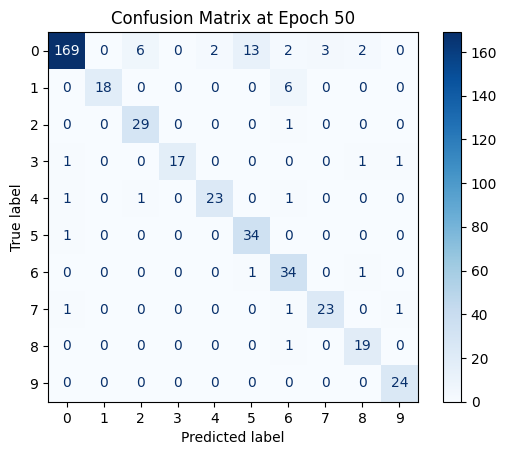

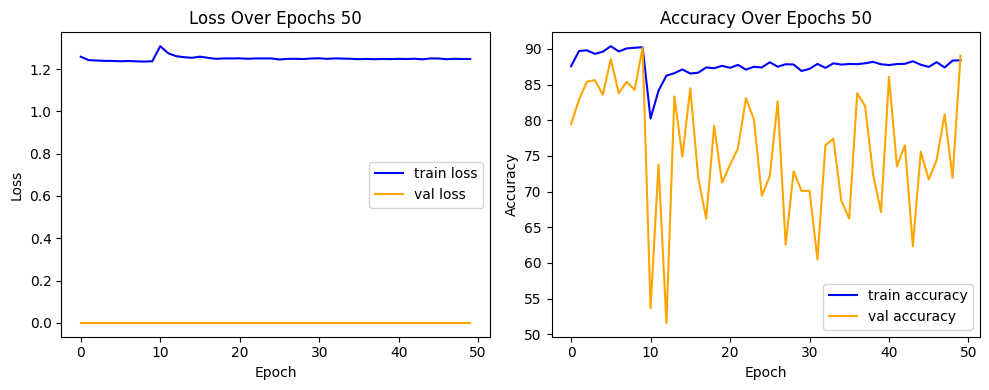

SP-[1] Epoch: 51/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.2467  Acc 88.50% | HA 0.00@0 | Val: Loss nan  Acc 81.28% | HA 0.00@0 | Sum 169.78 HA 0.00
SP-[1] Epoch: 52/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.2467  Acc 88.08% | HA 0.00@0 | Val: Loss nan  Acc 79.45% | HA 0.00@0 | Sum 167.53 HA 0.00
SP-[1] Epoch: 53/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.2482  Acc 87.47% | HA 0.00@0 | Val: Loss nan  Acc 73.74% | HA 0.00@0 | Sum 161.21 HA 0.00
SP-[1] Epoch: 54/300 | Time: 0m39s (Train 0m39s  Val 0m00s) | Train: lr 0.1  Loss 1.2500  Acc 87.63% | HA 0.00@0 | Val: Loss nan  Acc 76.03% | HA 0.00@0 | Sum 163.66 HA 0.00
SP-[1] Epoch: 55/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.1  Loss 1.2445  Acc 88.16% | HA 0.00@0 | Val: Loss nan  Acc 72.83% | HA 0.00@0 | Sum 160.99 HA 0.00
SP-[1] Epoch: 56/300 | Time: 0m39s (Train 0m39s  Val 0m00s) | Train: lr 0.1  Loss 1.2454  Acc 88.38% | HA 0.00@0 | Val: Loss nan  

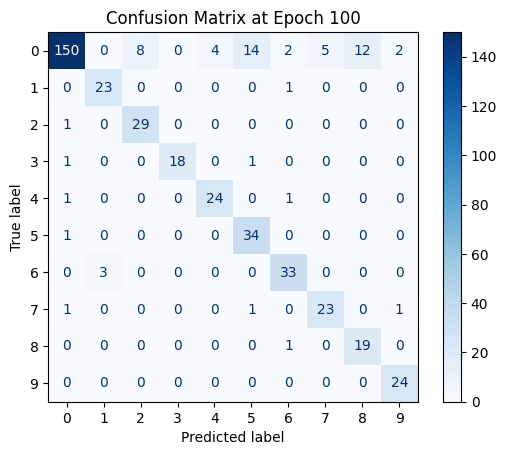

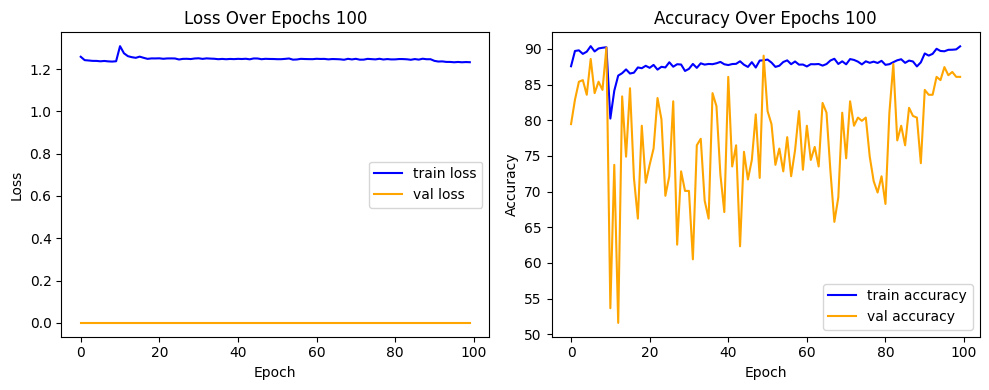

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_90.1826_valacc87.2146_tracc90.2764_epoch_101.pt
SP-[1] Epoch: 101/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2331  Acc 90.28% | HA 0.00@0 | Val: Loss nan  Acc 87.21% | HA 0.00@0 | Sum 177.49 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_90.1826_valacc86.5297_tracc90.1683_epoch_102.pt
SP-[1] Epoch: 102/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2324  Acc 90.17% | HA 0.00@0 | Val: Loss nan  Acc 86.53% | HA 0.00@0 | Sum 176.70 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_90.1826_valacc87.6712_tracc90.1

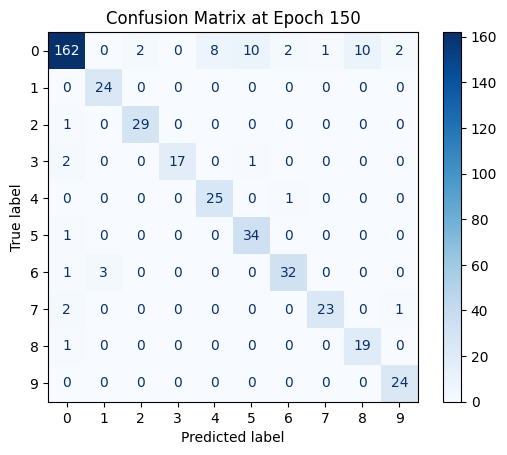

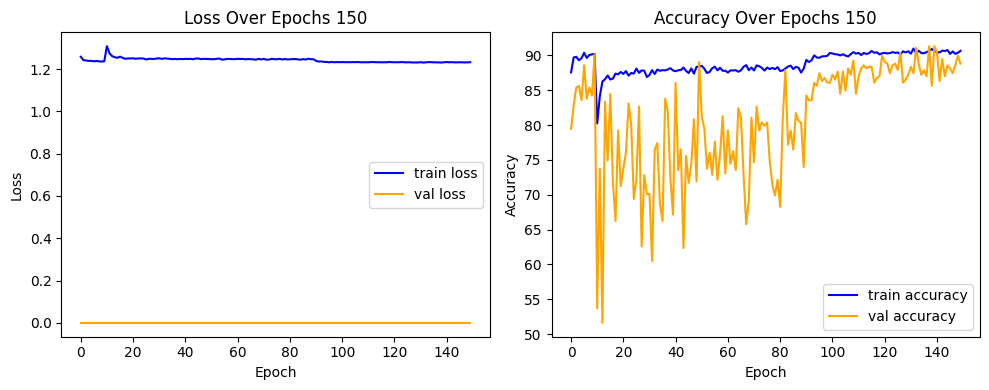

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.3242_valacc87.2146_tracc90.3666_epoch_151.pt
SP-[1] Epoch: 151/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2301  Acc 90.37% | HA 0.00@0 | Val: Loss nan  Acc 87.21% | HA 0.00@0 | Sum 177.58 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.3242_valacc88.8128_tracc90.6310_epoch_152.pt
SP-[1] Epoch: 152/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2310  Acc 90.63% | HA 0.00@0 | Val: Loss nan  Acc 88.81% | HA 0.00@0 | Sum 179.44 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.3242_valacc87.4429_tracc90

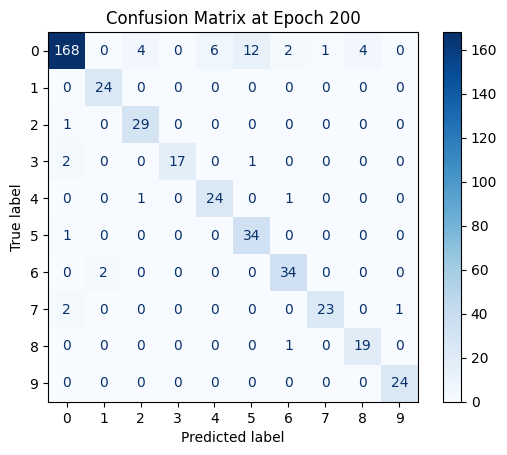

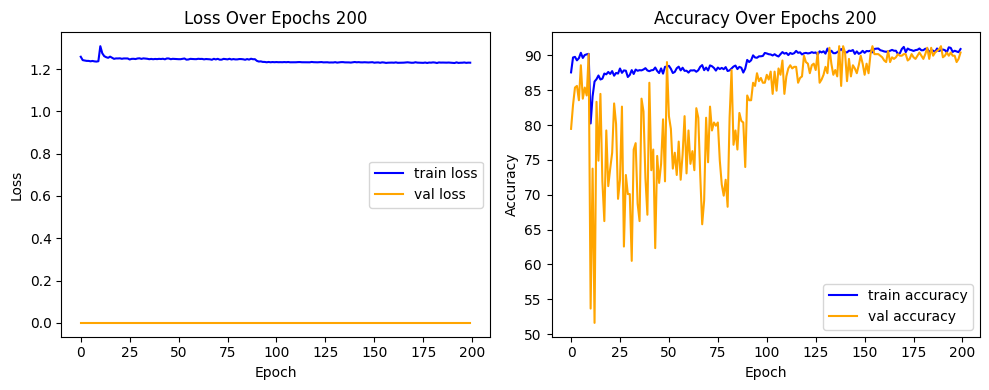

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.3242_valacc89.9543_tracc90.6190_epoch_201.pt
SP-[1] Epoch: 201/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2303  Acc 90.62% | HA 0.00@0 | Val: Loss nan  Acc 89.95% | HA 0.00@0 | Sum 180.57 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.3242_valacc90.4110_tracc90.6130_epoch_202.pt
SP-[1] Epoch: 202/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2312  Acc 90.61% | HA 0.00@0 | Val: Loss nan  Acc 90.41% | HA 0.00@0 | Sum 181.02 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.3242_valacc89.2694_tracc90

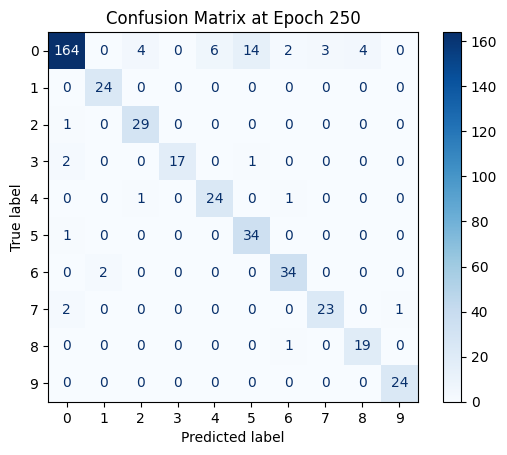

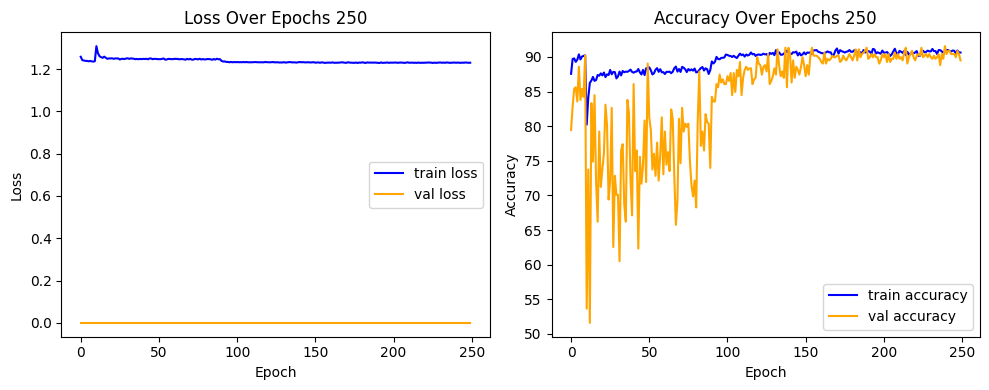

save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.5525_valacc89.9543_tracc90.3125_epoch_251.pt
SP-[1] Epoch: 251/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2310  Acc 90.31% | HA 0.00@0 | Val: Loss nan  Acc 89.95% | HA 0.00@0 | Sum 180.27 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.5525_valacc90.8676_tracc90.4988_epoch_252.pt
SP-[1] Epoch: 252/300 | Time: 0m40s (Train 0m40s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2305  Acc 90.50% | HA 0.00@0 | Val: Loss nan  Acc 90.87% | HA 0.00@0 | Sum 181.37 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.5525_valacc90.4110_tracc91

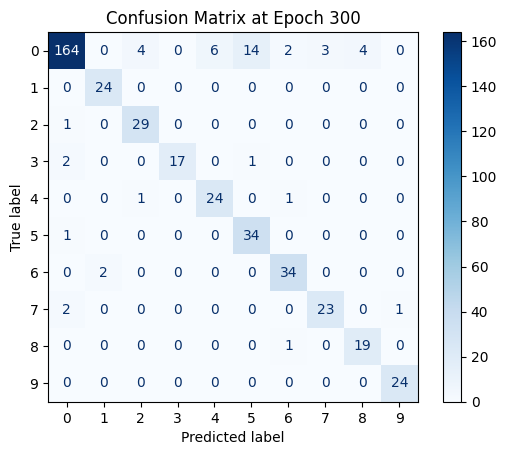

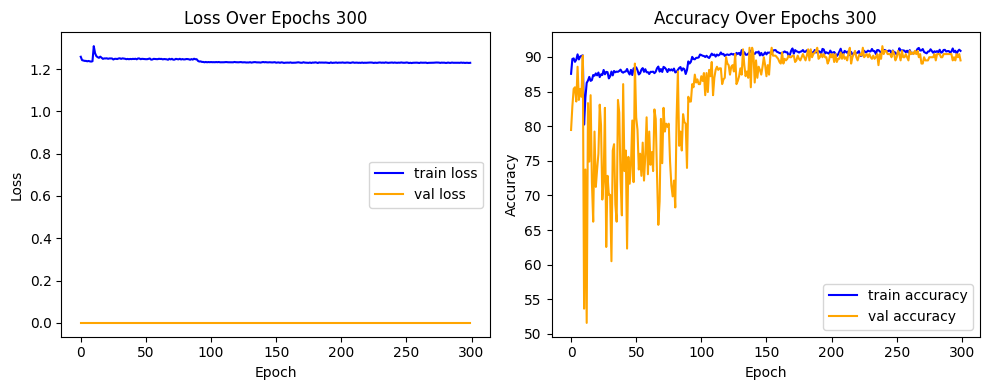

Execution finished in: 3h19m
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.5525_valacc89.4977_tracc90.8714_epoch_300.pt


In [21]:
step_2_model_path = main()


In [22]:
step_2_model_path

'/home/sail/sound_project/sound_ai_v4_4/sys/step_2_pruning/20241212_19/pruning_4C_time_2024121219_prunratio80.0/10C_model_v4_4_first_stage_prun_haacc_91.5525_valacc91.5525_tracc90.8774_epoch_240.pt'

## step3

In [23]:
# step_2_model_path = '/home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/9C_model_v4_first_stage_prun_haacc_92.5287_valacc91.3793_tracc97.9044_epoch_140.pt'

In [24]:
step_now = 'sys/step_3_pruning'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s3'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/save_pt_model_s3' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23' created successfully.


In [25]:
from pruning import PruningTrainer


In [26]:
def main():
    opt = getOpts()
    
    
    opt.prune_ratio = pr_rate # 0.9
    opt.prune_all = True;

    opt.base_model_path = step_2_model_path

    save_dir = f"{save_pt_model_path}/uec_secondPrun_time_{getDateStr()}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    opt.save_dir = save_dir;
    model_name = save_model_name+"second_stage_prun_ratio{}_{}.pt".format(opt.prune_ratio, genDataTimeStr());
    opt.model_name = save_dir + model_name;
    opt.logSaveDir = opt.save_dir+"/second_stage_pruning_logs/"
    ChkAndCreateSingleDir(opt.logSaveDir)
    # valid_path = False;
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt=opt)
    print("Start to pruning.....")
    trainer.PruneAndTrain();
    return opt.model_name

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0//second_stage_pruning_logs/' folder is created.
Initializing PruneAndTrain Object.....
device is: cuda:0
Start to pruning.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
 --- chonfig[1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
pruning algorithm is <th.resources.pruning_tools.filter_pruning.Taylor object at 0x7012b432c400>
Current Testing Performance - Val: Loss nan  Acc(top1) 91.553%
Total Channels: 256, Prunable: 256, Non-Prunable: 0
No. of Channels to prune per iteration: 1
Total Channels to prune (80%): 203
Total iterations required: 203

Iteration 1 of 203 starts..
Ranking channels.. 


/home/sail/sound_project/sound_ai_v4_5/sys/pruning.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(trained_model, map_location=self.

new_conv Conv2d(1, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 91.096%
Fine tuning 2 epochs to recover from prunning iteration.
config[16, 32, 63, 32, 64, 32, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2

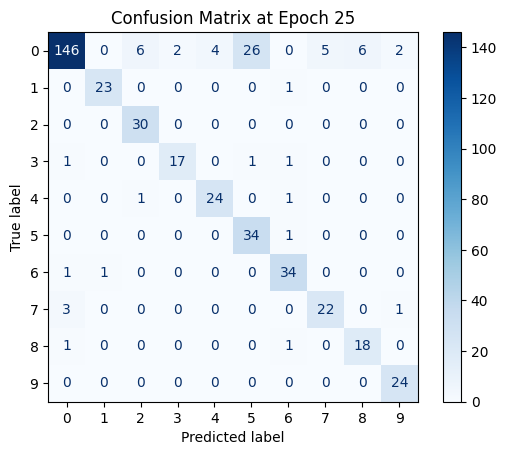

Current Testing Performance - Val: Loss 0.355  Acc(top1) 7.991%
Current Testing Performance - Val: Loss nan  Acc(top1) 79.224%
Finished fine tuning.
Iteration 24/205 finished in 1m58s
Total channels prunned so far: 24
 --- chonfig[16, 32, 48, 30, 60, 30, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 25 of 203 starts..
Ranking channels.. 
new_conv Conv2d(30, 59, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(59, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 75.114%
Fine tuning 2 epochs to recover from prunning iteration.
config[16, 32, 48, 30, 59, 30, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 9), stride=(1, 2), bias=False)


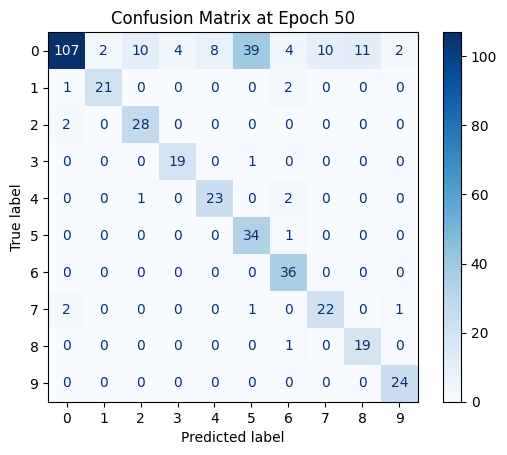

Current Testing Performance - Val: Loss 1.751  Acc(top1) 4.566%
Current Testing Performance - Val: Loss nan  Acc(top1) 77.626%
Finished fine tuning.
Iteration 49/205 finished in 1m58s
Total channels prunned so far: 49
 --- chonfig[14, 32, 44, 27, 51, 24, 15]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 50 of 203 starts..
Ranking channels.. 
new_conv Conv2d(1, 43, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 83.790%
Fine tuning 2 epochs to recover from prunning iteration.
config[14, 32, 43, 27, 51, 24, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 14, kernel_size=(1, 9), stride=(1, 2), bias=False)
 

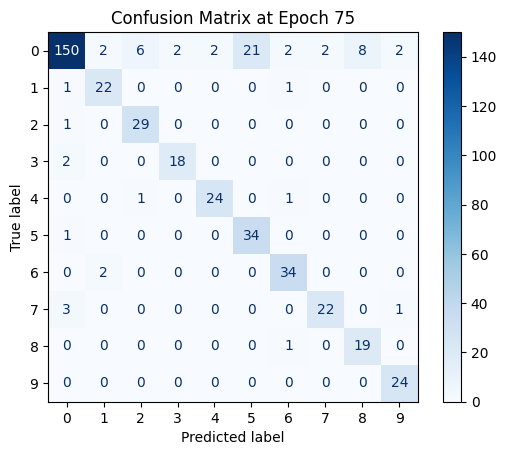

Current Testing Performance - Val: Loss nan  Acc(top1) 88.584%
Current Testing Performance - Val: Loss nan  Acc(top1) 86.301%
Finished fine tuning.
Iteration 74/205 finished in 2m11s
Total channels prunned so far: 74
 --- chonfig[8, 32, 40, 24, 45, 24, 15]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 75 of 203 starts..
Ranking channels.. 
Skipping pruning for layer 0 as it would reduce channels below 4
Current Testing Performance - Val: Loss nan  Acc(top1) 85.845%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 40, 24, 45, 24, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): 

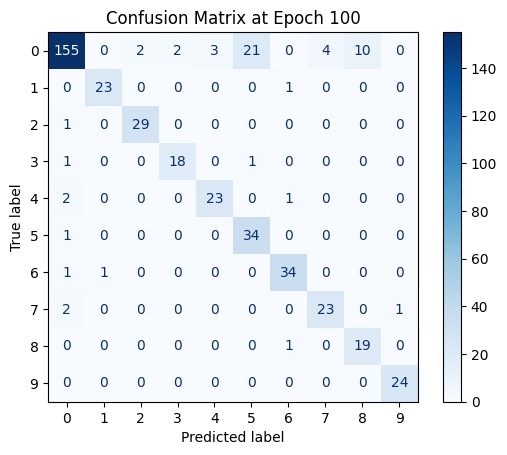

Current Testing Performance - Val: Loss nan  Acc(top1) 85.160%
Current Testing Performance - Val: Loss nan  Acc(top1) 88.128%
Finished fine tuning.
Iteration 99/205 finished in 2m11s
Total channels prunned so far: 99
 --- chonfig[8, 32, 36, 24, 43, 23, 15]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 100 of 203 starts..
Ranking channels.. 
new_conv Conv2d(43, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 83.105%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 36, 24, 43, 22, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
   

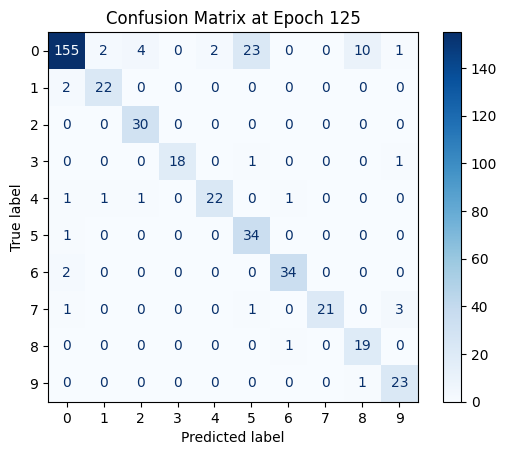

Current Testing Performance - Val: Loss nan  Acc(top1) 84.247%
Current Testing Performance - Val: Loss nan  Acc(top1) 85.616%
Finished fine tuning.
Iteration 124/205 finished in 2m11s
Total channels prunned so far: 124
 --- chonfig[8, 32, 31, 22, 38, 19, 15]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 125 of 203 starts..
Ranking channels.. 
new_conv Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 79.909%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 30, 22, 38, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
  

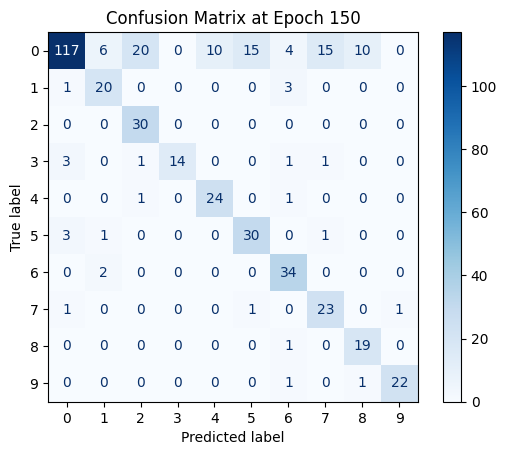

Current Testing Performance - Val: Loss nan  Acc(top1) 76.712%
Current Testing Performance - Val: Loss nan  Acc(top1) 77.854%
Finished fine tuning.
Iteration 149/205 finished in 2m10s
Total channels prunned so far: 149
 --- chonfig[8, 32, 25, 18, 32, 16, 15]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 150 of 203 starts..
Ranking channels.. 
new_conv Conv2d(32, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 71.461%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 25, 18, 32, 15, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
 

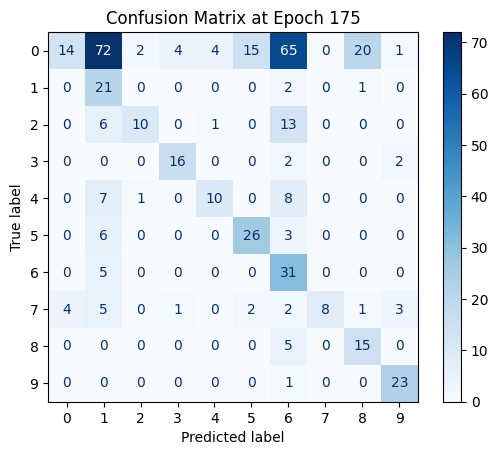

Current Testing Performance - Val: Loss nan  Acc(top1) 67.808%
Current Testing Performance - Val: Loss nan  Acc(top1) 68.037%
Finished fine tuning.
Iteration 174/205 finished in 2m12s
Total channels prunned so far: 174
 --- chonfig[8, 32, 18, 14, 22, 14, 15]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 175 of 203 starts..
Ranking channels.. 
new_conv Conv2d(14, 21, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 60.274%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 18, 14, 21, 14, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
 

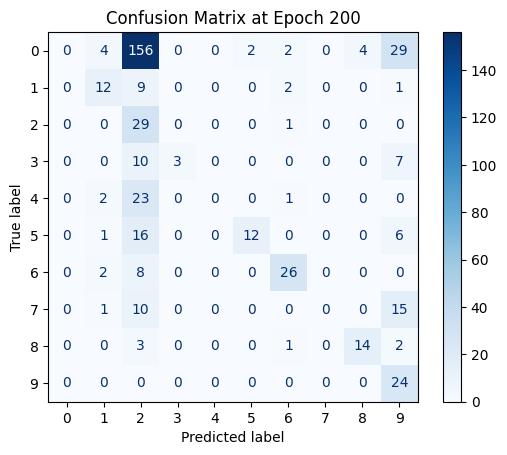

Current Testing Performance - Val: Loss 0.275  Acc(top1) 45.205%
Current Testing Performance - Val: Loss 0.196  Acc(top1) 44.521%
Finished fine tuning.
Iteration 199/205 finished in 1m54s
Total channels prunned so far: 199
 --- chonfig[8, 32, 15, 11, 16, 10, 13]
 --- save model at /home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt --- 

Iteration 200 of 203 starts..
Ranking channels.. 
new_conv Conv2d(1, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss 0.703  Acc(top1) 39.041%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 14, 11, 16, 10, 13]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=Fal

In [27]:
step_3_model_path = main()

In [28]:
step_3_model_path 

'/home/sail/sound_project/sound_ai_v4_4/sys/step_3_pruning/20241212_23/uec_secondPrun_time_2024121223_prunratio80.0/10C_model_v4_4second_stage_prun_ratio0.8_20241212231721.pt'

## step4

In [29]:
# step_3_model_path = '/home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241120_19/uec_secondPrun_time_2024112019_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241120191710.pt'

In [30]:
step_now = 'sys/step_4_retrain'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s4'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")

try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/save_pt_model_s4' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06' created successfully.


In [31]:
from retrain import ReTrainer

In [32]:
def main():

    opt = getOpts();

    # opt.lr = 0.1
    # opt.nEpochs = ; # 1600
    # opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;
    
    # opt.least_save_epoch = 10;
    opt.first_save_acc = 60.0;
    opt.save_val_acc = 95.0;
    opt.save_train_acc = 90.0;

    opt.pruningRatio = pr_rate
    
    save_dir = "{}/retrain_4C_after_2nd_pruning_prunratio{}_{}/".format(save_pt_model_path,opt.pruningRatio,getDateStr());
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.logSaveDir = save_dir
    print(f"save dir is: {save_dir}");
    opt.second_pruned_model = step_3_model_path

    opt.saveDir = save_dir;
    # opt.device="mps";
    if torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"
    print(f"***Use device:{opt.device}");
    # opt.device = torch.device("cuda:0" if  else "cpu");

    opt.model_name = save_model_name+"retrained_ratio{:.4f}_vaacc{:.4f}_tracc_{:.4f}@{}epoch.pt"
    
    #Starting retraining process
    trainer = ReTrainer(opt=opt);
    trainer.Train();
    return opt.best_save_name

***Use device:cuda:0
save dir is: /home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/
***Use device:cuda:0
device is: cuda:0
config is [8, 32, 14, 11, 16, 9, 13]
self.opt.config [8, 32, 14, 11, 16, 9, 13]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (8, 1, 7996)         72      575,712
  BatchNorm2d-2      (8, 1, 7996)      (8, 1, 7996)         16            0
         ReLu-3      (8, 1, 7996)      (8, 1, 7996)          0       63,968
       Conv2d-4      (8, 1, 7996)     (32, 1, 3996)      1,280    5,114,880
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 39

/home/sail/sound_project/sound_ai_v4_5/sys/retrain.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(self.opt.second_pruned_model, map_location="cuda")

shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 1/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.36  Acc 74.08% | Val: Loss 0.25  Acc(top1) 43.61%  HA 0.00| best sum 0.00@0


/home/sail/sound_project/sound_ai_v4_5/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 2/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.33  Acc 78.60% | Val: Loss 0.20  Acc(top1) 49.09%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 3/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.31  Acc 79.89% | Val: Loss 0.23  Acc(top1) 48.86%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 4/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.31  Acc 80.94% | Val: Loss 0.18  Acc(top1) 47.95%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 5/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.30  Acc 81.40% | Val: Loss 0.12  Acc(top1) 49.54%  HA 0.00| 

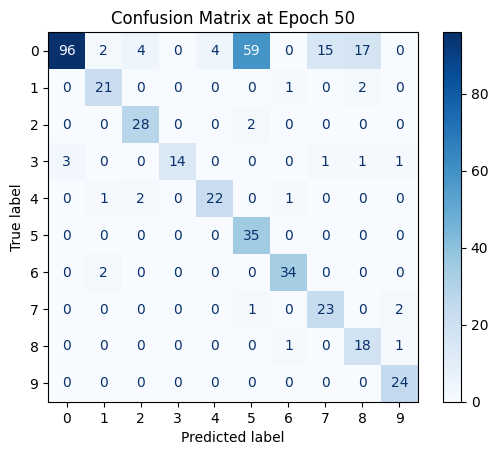

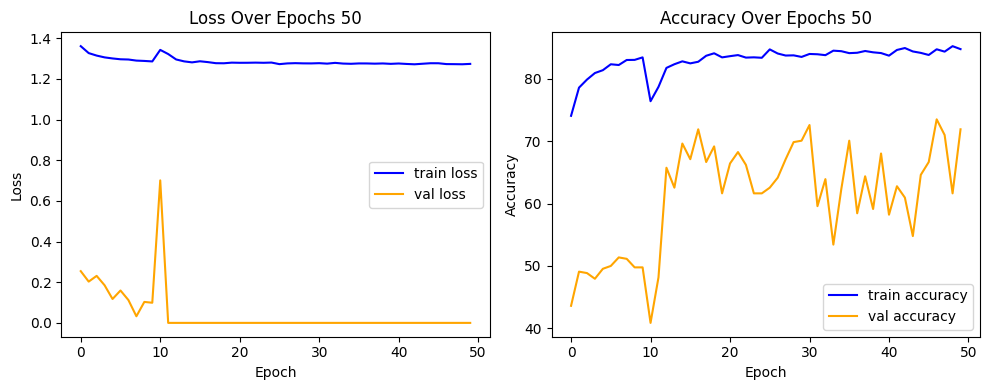

shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 51/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: LR 0.1  Loss 1.27  Acc 85.19% | Val: Loss nan  Acc(top1) 70.78%  HA 73.52| best sum 316.74@47


/home/sail/sound_project/sound_ai_v4_5/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 52/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: LR 0.1  Loss 1.27  Acc 85.12% | Val: Loss nan  Acc(top1) 58.45%  HA 73.52| best sum 316.74@47
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 53/300 | Time: 0m51s (Train 0m50s  Val 0m00s) | Train: LR 0.1  Loss 1.27  Acc 84.32% | Val: Loss nan  Acc(top1) 69.86%  HA 73.52| best sum 316.74@47
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 54/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.1  Loss 1.27  Acc 84.00% | Val: Loss nan  Acc(top1) 58.68%  HA 73.52| best sum 316.74@47
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 55/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.1  Loss 1.27  Acc 84.57% | Val: Loss nan  Acc(top1) 71.00%  HA 73.52| best sum 316.74@47
shape of y_pred:torch.Size([438, 10]

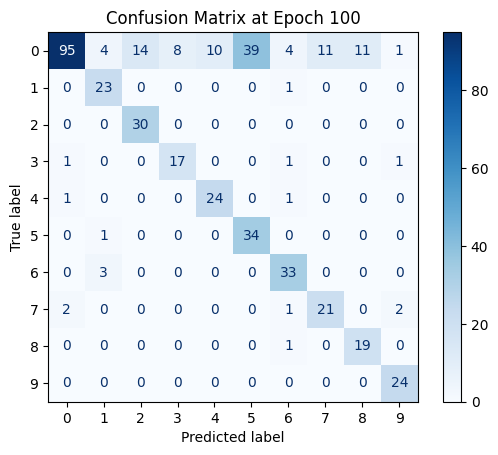

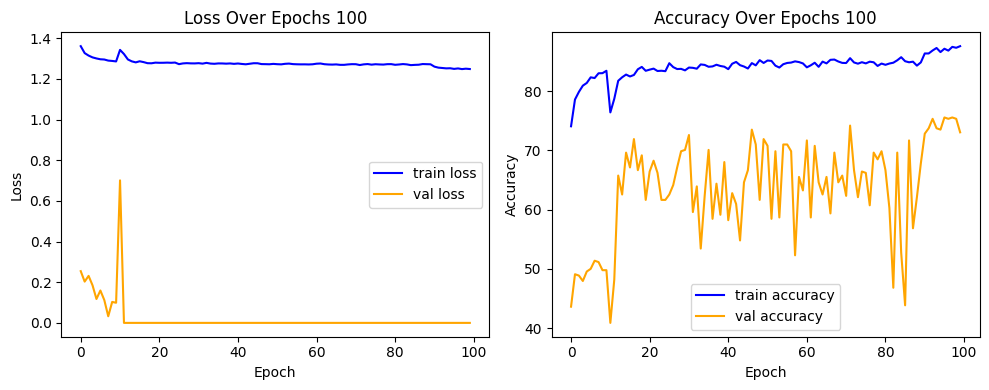

shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/10C_model_v4_4retrained_ratio80.0000_vaacc74.4292_tracc_87.6743@101epoch.pt
SP-[1] Epoch: 101/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.25  Acc 87.67% | Val: Loss nan  Acc(top1) 74.43%  HA 75.57| best sum 326.13@96


/home/sail/sound_project/sound_ai_v4_5/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 102/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.25  Acc 87.52% | Val: Loss nan  Acc(top1) 74.20%  HA 75.57| best sum 326.13@96
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/10C_model_v4_4retrained_ratio80.0000_vaacc75.3425_tracc_88.0288@103epoch.pt
SP-[1] Epoch: 103/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.25  Acc 88.03% | Val: Loss nan  Acc(top1) 75.34%  HA 75.57| best sum 326.97@96
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/10C_model_v4_4retrained_ratio80.0000_vaacc77.1689_trac

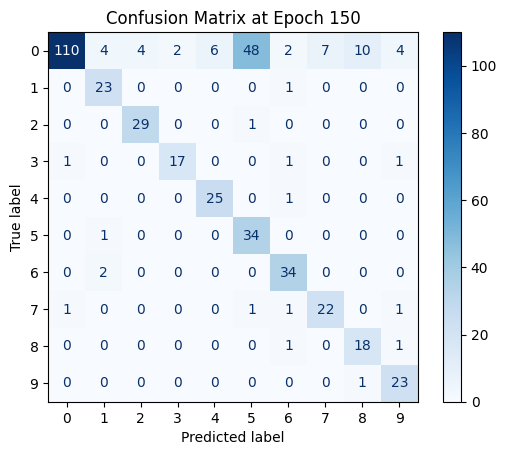

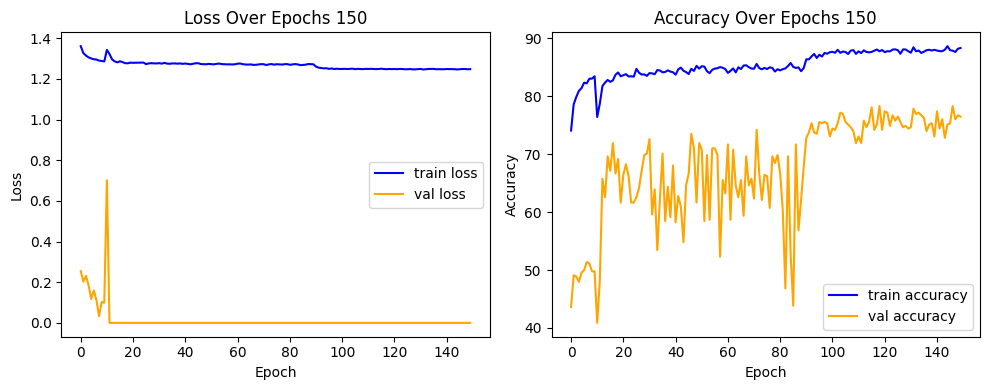

shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 151/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.25  Acc 87.92% | Val: Loss nan  Acc(top1) 76.26%  HA 78.31| best sum 333.15@147


/home/sail/sound_project/sound_ai_v4_5/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/10C_model_v4_4retrained_ratio80.0000_vaacc78.5388_tracc_88.2812@152epoch.pt
SP-[1] Epoch: 152/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.25  Acc 88.28% | Val: Loss nan  Acc(top1) 78.54%  HA 78.54| best sum 334.01@152
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 153/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.25  Acc 88.38% | Val: Loss nan  Acc(top1) 76.26%  HA 78.54| best sum 334.01@152
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 154/300 | Time: 0m52s (Train 0m52s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.36% | Val: Loss nan  Acc(top1) 76.94%  HA 78.54| best sum 334.01@152
shap

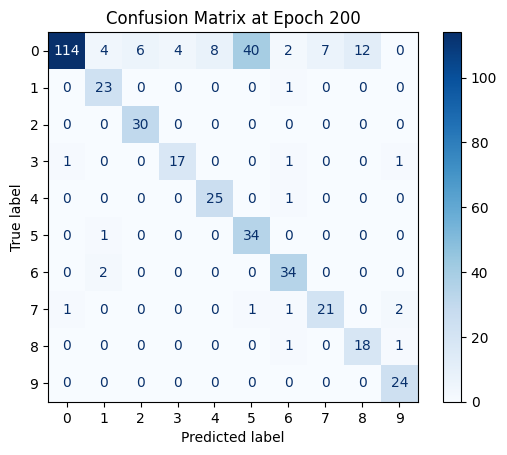

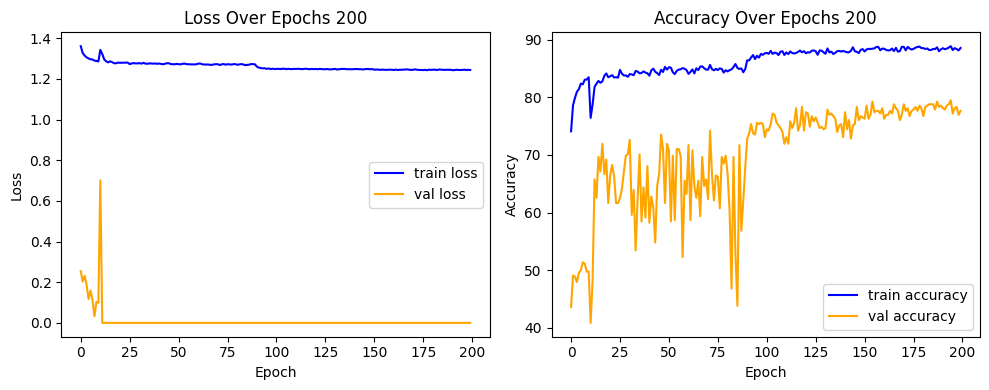

shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 201/300 | Time: 0m52s (Train 0m52s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.26% | Val: Loss nan  Acc(top1) 76.94%  HA 79.22| best sum 336.37@188


/home/sail/sound_project/sound_ai_v4_5/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 202/300 | Time: 0m53s (Train 0m53s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.24% | Val: Loss nan  Acc(top1) 77.40%  HA 79.22| best sum 336.37@188
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 203/300 | Time: 0m52s (Train 0m52s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.67% | Val: Loss nan  Acc(top1) 77.40%  HA 79.22| best sum 336.37@188
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 204/300 | Time: 0m53s (Train 0m52s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.33% | Val: Loss nan  Acc(top1) 77.40%  HA 79.22| best sum 336.37@188
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 205/300 | Time: 0m53s (Train 0m53s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 87.93% | Val: Loss nan  Acc(

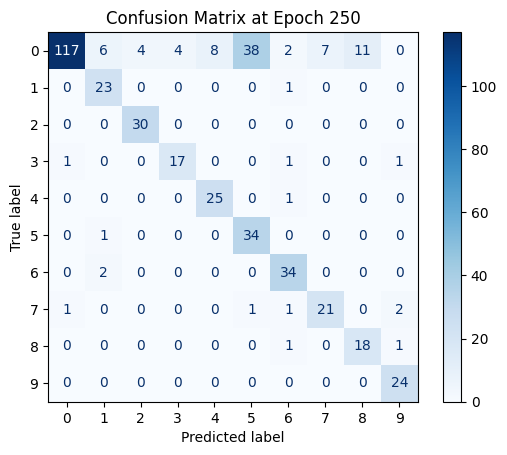

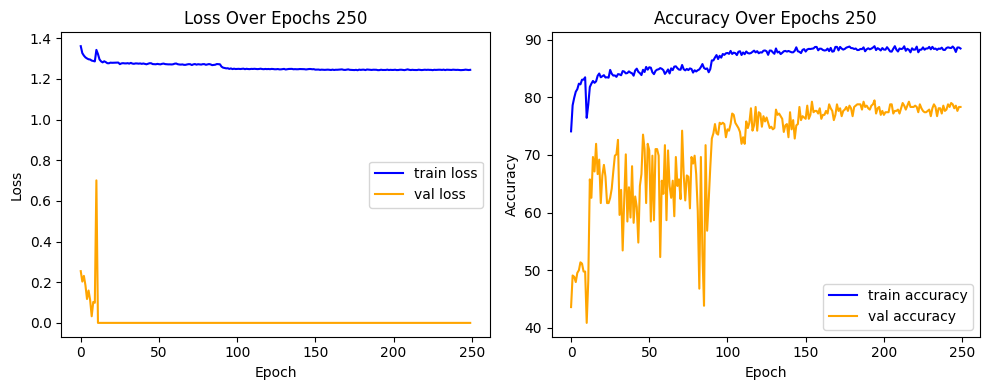

shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 251/300 | Time: 0m55s (Train 0m54s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.25  Acc 87.86% | Val: Loss nan  Acc(top1) 77.85%  HA 79.22| best sum 336.37@217


/home/sail/sound_project/sound_ai_v4_5/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 252/300 | Time: 0m57s (Train 0m57s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.29% | Val: Loss nan  Acc(top1) 77.63%  HA 79.22| best sum 336.37@217
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
save model to /home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/10C_model_v4_4retrained_ratio80.0000_vaacc77.3973_tracc_88.8882@253epoch.pt
SP-[1] Epoch: 253/300 | Time: 0m53s (Train 0m53s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.89% | Val: Loss nan  Acc(top1) 77.40%  HA 79.22| best sum 336.37@217
shape of y_pred:torch.Size([438, 10])
shape of y_target:torch.Size([438, 10])
SP-[1] Epoch: 254/300 | Time: 0m52s (Train 0m52s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.24  Acc 88.71% | Val: Loss nan  Acc(top1) 78.31%  HA 79.22| best sum 336.37@217
shap

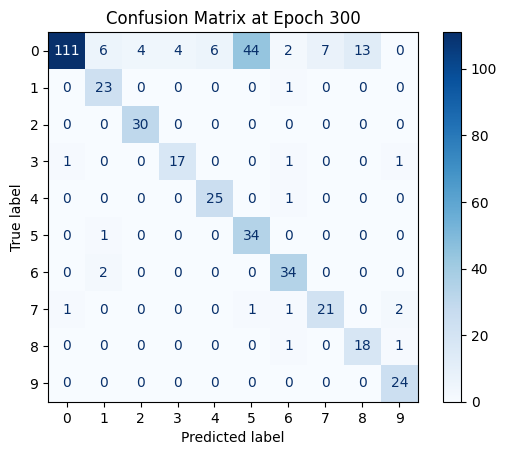

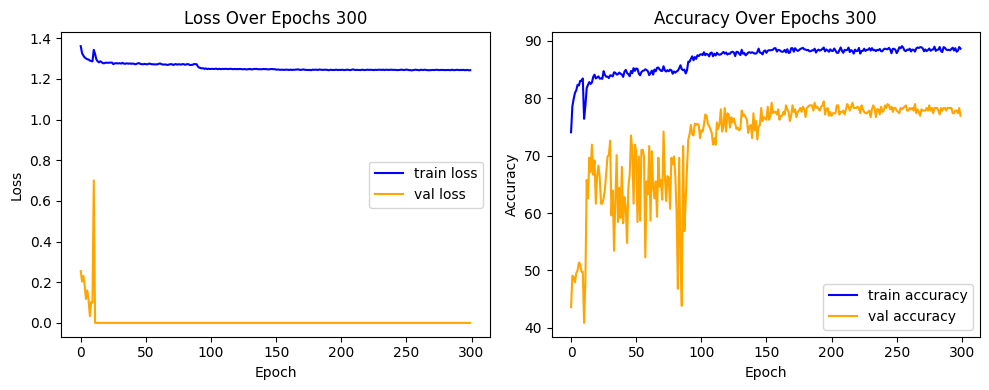

Execution finished in: 4h19m


In [33]:
step_4_model_path = main()

In [34]:
step_4_model_path

'/home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/10C_model_v4_4retrained_ratio80.0000_vaacc79.4521_tracc_88.8462@195epoch.pt'

## step5

In [35]:
# step_4_model_path = '/home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241028_09/retrain_4C_after_2nd_pruning_prunratio0.9_2024102809/9C_model_v4retrained_ratio90.0000_vaacc95.4023_tracc_90.8088@285epoch.pt'

In [36]:
step_now = 'sys/step_5_conv_int8'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s5'
save_pt_model_path = f'{save_step_path}/{date_time}'


In [37]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5/{date_time}'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_pt_model_path+'/uncompressed_qat_models')
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")
    
try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_5_conv_int8/save_pt_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_5_conv_int8/save_tflite_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_5_conv_int8/save_pt_model_s5/20241213_10' created successfully.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_5_conv_int8/save_pt_model_s5/20241213_10' created successfully.
Folder '/home/sail/sound_project/sound_ai_v4_4/sys/step_5_conv_int8/save_tflite_model_s5/20241213_10' created successfully.


In [38]:
def display_info(opt):
    print('+------------------------------+');
    print('| {} Sound classification'.format(opt.netType));
    print('+------------------------------+');
    print('| dataset  : {}'.format(opt.dataset));
    print('| nEpochs  : {}'.format(opt.nEpochs));
    print('| LRInit   : {}'.format(opt.lr));
    print('| schedule : {}'.format(opt.schedule));
    print('| warmup   : {}'.format(opt.warmup));
    print('| batchSize: {}'.format(opt.batchSize));
    print('| nFolds: {}'.format(opt.nFolds));
    print('| Splits: {}'.format(opt.splits));
    print('| Device: {}'.format(opt.device));
    print('| Model Path: {}'.format(opt.model_path));
    print('| Model Name: {}'.format(opt.model_name));
    print('+------------------------------+');

In [39]:
from convint8 import QATTrainer

In [40]:
def main():
    opt = getOpts();#opts.parse();
    opt.device = 'cpu';
    opt.saveInfo = "uec_v2.2_sail1014"
    opt.model_path = step_4_model_path

    opt.save_tflite_model_path = save_tflite_model_path
    opt.logSaveDir = opt.save_tflite_model_path 
    opt.save_pt_model_path = save_pt_model_path
    timeStr = genDataTimeStr();
    opt.model_name = save_model_name+"qat_model_{}_{}".format(opt.saveInfo,timeStr);
   
    opt.lr = 0.01; # 0.1
    opt.nEpochs = 150; # 1600
    # opt.schedule = [0.05, 0.1, 0.3, 0.5];
    opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;

    opt.split = 1;
    opt.hasQuated = False;
    display_info(opt);
    trainer = QATTrainer(opt);

    print('Testing performance of the provided model.....');
    trainer.TestModel();

    print('Quantization process is started.....');
    trainer.QuantizeModel();
    print('Quantization done');

    return opt.tflite_path
    # print('Testing quantized model.');
    # trainer.TestModel(True);
    # print('Finished');

***Use device:cuda:0
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v4
| nEpochs  : 150
| LRInit   : 0.01
| schedule : [0.001, 0.003, 0.005, 0.01]
| warmup   : 10
| batchSize: 128
| nFolds: 1
| Splits: [1]
| Device: cpu
| Model Path: /home/sail/sound_project/sound_ai_v4_4/sys/step_4_retrain/20241213_06/retrain_4C_after_2nd_pruning_prunratio0.8_2024121306/10C_model_v4_4retrained_ratio80.0000_vaacc79.4521_tracc_88.8462@195epoch.pt
| Model Name: 10C_model_v4_4qat_model_uec_v2.2_sail1014_20241213104016
+------------------------------+
device is: cpu
Testing performance of the provided model.....
has not quanted, load unquanted model...
[1, 8, 32, 1, 14, 11, 16, 9, 13, 10]
self.ch_config [1, 8, 32, 1, 14, 11, 16, 9, 13, 10]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
--------------------------------------------

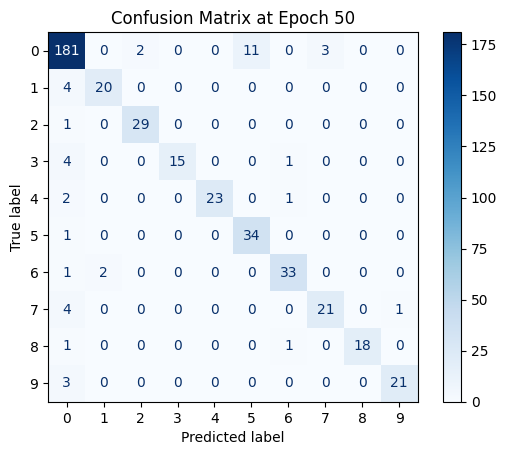

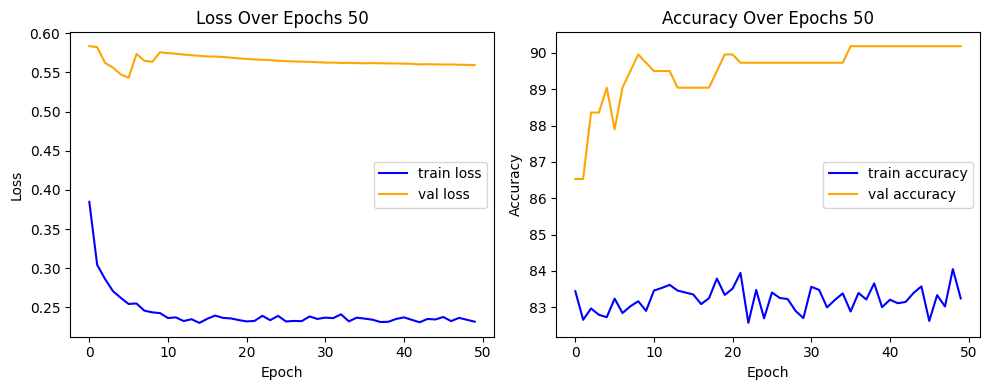

current best Acc is 90.18264770507812
pass in acc is 90.18264770507812
SP-[1] Epoch: 51/150 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.23  Acc 83.44% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.18@36
current best Acc is 90.18264770507812
pass in acc is 90.18264770507812
SP-[1] Epoch: 52/150 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.23  Acc 83.41% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.18@36
current best Acc is 90.18264770507812
pass in acc is 90.18264770507812
SP-[1] Epoch: 53/150 | Time: 0m51s (Train 0m50s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.23  Acc 82.99% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.18@36
current best Acc is 90.18264770507812
pass in acc is 90.18264770507812
SP-[1] Epoch: 54/150 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.24  Acc 83.26% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.18@36
current best Acc is 90.18264770507812
pass in ac

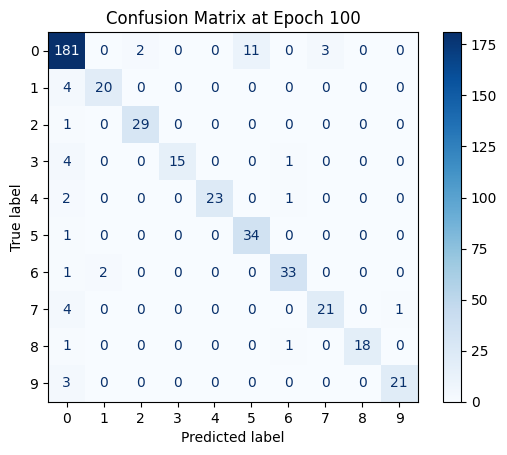

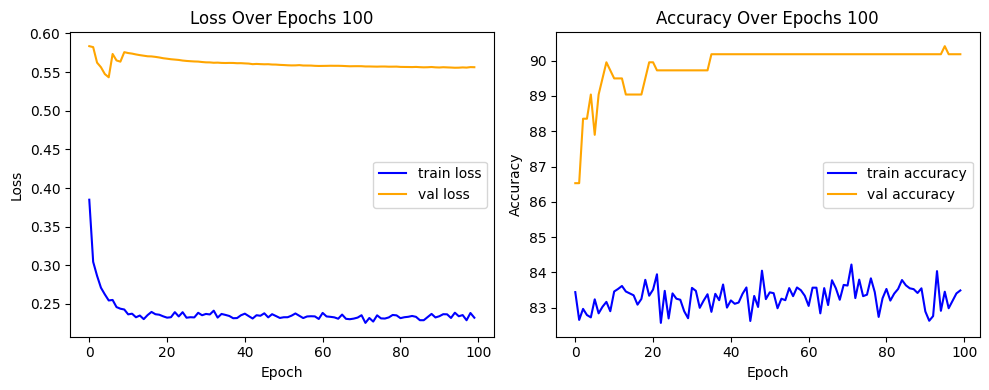

current best Acc is 90.41095733642578
pass in acc is 90.18264770507812
SP-[1] Epoch: 101/150 | Time: 2m08s (Train 2m08s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.24  Acc 83.31% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.41@96
current best Acc is 90.41095733642578
pass in acc is 90.18264770507812
SP-[1] Epoch: 102/150 | Time: 2m10s (Train 2m10s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.23  Acc 83.36% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.41@96
current best Acc is 90.41095733642578
pass in acc is 90.18264770507812
SP-[1] Epoch: 103/150 | Time: 2m16s (Train 2m16s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.23  Acc 84.09% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.41@96
current best Acc is 90.41095733642578
pass in acc is 90.18264770507812
SP-[1] Epoch: 104/150 | Time: 2m12s (Train 2m11s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.23  Acc 83.83% | Val: Loss 0.56  Acc(top1) 90.18% | HA 90.41@96
current best Acc is 90.41095733642578
pass i

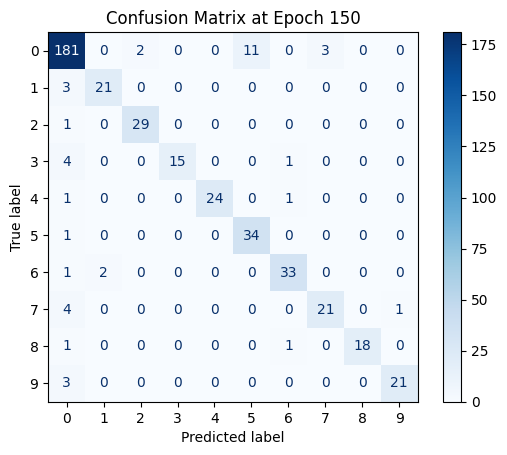

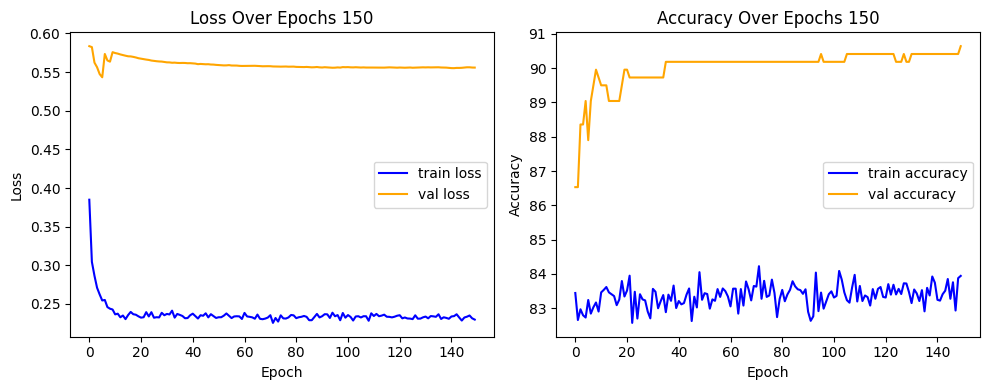

Execution finished in: 3h55m
Post Training Quantization: Convert done
Size of model after quantization
Size (MB): 0.016894
device is: cpu
torch.Size([438, 10])
Testing: Acc(top1) 90.64%


INFO (tinynn.converter.base) Generated model saved to /home/sail/sound_project/sound_ai_v4_4/sys/step_5_conv_int8/save_tflite_model_s5/20241213_10/10C_model_v4_4qat_model_uec_v2.2_sail1014_20241213104016.tflite


Quantization done


In [41]:
tflite_path = main()

## check

In [42]:
tflite_path

'/home/sail/sound_project/sound_ai_v4_4/sys/step_5_conv_int8/save_tflite_model_s5/20241213_10/10C_model_v4_4qat_model_uec_v2.2_sail1014_20241213104016.tflite'

In [43]:
import tensorflow as tf


interpreter = tf.lite.Interpreter(model_path=tflite_path)

interpreter.allocate_tensors()

# 獲取張量細節
tensor_details = interpreter.get_tensor_details()

# 檢查每個張量的類型
for tensor in tensor_details:
    tensor_name = tensor['name']
    tensor_type = tensor['dtype']
    print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# 檢查輸入和輸出張量的類型
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nInput Tensors:")
for input_tensor in input_details:
    print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

print("\nOutput Tensors:")
for output_tensor in output_details:
    print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


2024-12-13 14:36:11.094733: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 14:36:11.104284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 14:36:11.112018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 14:36:11.114223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 14:36:11.123134: I tensorflow/core/platform/cpu_feature_guar

Tensor: fuse_attr_2, Type: <class 'numpy.int32'>
Tensor: fuse_attr_9, Type: <class 'numpy.int8'>
Tensor: fuse_attr_5, Type: <class 'numpy.int8'>
Tensor: input.14_attr_1, Type: <class 'numpy.int32'>
Tensor: input.2_attr_1, Type: <class 'numpy.int32'>
Tensor: 124, Type: <class 'numpy.int8'>
Tensor: input.1_transform_1, Type: <class 'numpy.int8'>
Tensor: Xq.1_attr_1, Type: <class 'numpy.int32'>
Tensor: fuse_attr_11, Type: <class 'numpy.int32'>
Tensor: fuse_attr_8, Type: <class 'numpy.int8'>
Tensor: input.12_attr_1, Type: <class 'numpy.int32'>
Tensor: input.14_te_transform_1_te_transform_2, Type: <class 'numpy.int8'>
Tensor: input.2_te_transform, Type: <class 'numpy.int8'>
Tensor: input.14_te_transform, Type: <class 'numpy.int8'>
Tensor: input.4_transform, Type: <class 'numpy.int8'>
Tensor: fuse_attr_4, Type: <class 'numpy.int8'>
Tensor: input.10_transform, Type: <class 'numpy.int8'>
Tensor: fuse_attr_6, Type: <class 'numpy.int8'>
Tensor: input.6_te_transform, Type: <class 'numpy.int8'>
Te

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [44]:
tensor_details

[{'name': 'fuse_attr_2',
  'index': 0,
  'shape': array([4], dtype=int32),
  'shape_signature': array([4], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'fuse_attr_9',
  'index': 1,
  'shape': array([13,  1,  1,  9], dtype=int32),
  'shape_signature': array([13,  1,  1,  9], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.3707403540611267, 0),
  'quantization_parameters': {'scales': array([0.37074035], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'fuse_attr_5',
  'index': 2,
  'shape': array([14,  3,  3,  1], dtype=int32),
  'shape_signature': array([14,  3,  3,  1], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.006050680764019489, 0),
  'quantization_parameters': {'scales': array([0.006

# 

In [45]:
tflite_ = tflite_path
tflite_.split('/')[0]

''

In [46]:
c_ = f"/{tflite_.split('/')[1]}/{tflite_.split('/')[2]}/{tflite_.split('/')[3]}/{tflite_.split('/')[4]}/{tflite_.split('/')[5]}/{tflite_.split('/')[6]}/{tflite_.split('/')[7]}/{tflite_.split('/')[8]}/{save_name}"#tflite_[:-7]+'.cc'

! xxd -i {tflite_} > {c_}
REPLACE_TEST = f"model_9C_{today}_bysail";
!sed -i 's/'{REPLACE_TEST}'/g_model/g' {c_}

In [47]:
import tensorflow as tf
import numpy as np

def calculate_arena_size(tflite_model_path):
    """
    計算 TFLite 模型的內存需求（Arena size）。

    :param tflite_model_path: .tflite 模型文件的路徑
    :return: 估算的總內存需求（MB）
    """
    # 加載 TFLite 模型
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # 獲取所有張量的詳細信息
    tensor_details = interpreter.get_tensor_details()

    # 計算參數內存
    total_params = 0
    params_memory = 0
    activations_memory = 0

    for tensor in tensor_details:
        name = tensor['name'].lower()
        shape = tensor['shape']
        dtype = tensor['dtype']

        # 根據數據類型確定每個元素的字節數
        if dtype == np.float32:
            bytes_per_element = 4
        elif dtype == np.int8:
            bytes_per_element = 1
        elif dtype == np.int16:
            bytes_per_element = 2
        elif dtype == np.uint8:
            bytes_per_element = 1
        else:
            bytes_per_element = 4  # 默認為 float32

        tensor_size_mb = (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # 轉換為 MB

        # 假設 'weight' 和 'bias' 為參數，其他為激活
        if 'weight' in name or 'bias' in name:
            total_params += np.prod(shape)
            params_memory += (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # MB
        else:
            activations_memory += tensor_size_mb  # MB

    # 臨時內存估算（假設激活內存的 20% 為臨時內存）
    temporary_memory = activations_memory * 0.2

    # 總內存需求
    total_memory = params_memory + activations_memory + temporary_memory

    print(f"dtype：{dtype} ")
    print(f"參數內存需求：{params_memory:.2f} MB")
    print(f"激活內存需求：{activations_memory:.2f} MB")
    print(f"臨時內存需求（估算）：{temporary_memory:.2f} MB")
    print(f"總內存需求（估算的 Arena size）：{total_memory:.2f} MB")

    return total_memory

# 使用範例
tflite_model = tflite_path
arena_size = calculate_arena_size(tflite_model)

dtype：<class 'numpy.int32'> 
參數內存需求：0.00 MB
激活內存需求：0.27 MB
臨時內存需求（估算）：0.05 MB
總內存需求（估算的 Arena size）：0.32 MB


In [48]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path='/hd/Rick/desktop/Works/Projects/TransferLearning_for_ACDNet/Finall_Models_Save/Alarm_Detection/Pruning_Ratio_0.6_0.85_20240221/qat_model_0.6_0.85_ratio_qatacc_95.4_20240221181601_total_epochs_200.tflite')

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


In [49]:
# tensor_details

In [50]:
# import re

# # 假設模型數據存儲在名為 model.cc 的文件中
# input_file = '/home/sail/sound_project/sound_ai_v2/sys/step_5_conv_int8/save_tflite_model_s5/20241015_09/model_9C_v222_1015_pr09_byChristine.cc'
# output_file = 'model.tflite'

# # 讀取 C 文件
# with open(input_file, 'r') as f:
#     data = f.read()

# # 正則表達式匹配模型數據陣列
# match = re.search(r'unsigned char [^;]+', data, re.DOTALL)
# if not match:
#     raise ValueError("未找到模型數據陣列。請檢查文件內容。")

# # 提取十六進制數據
# hex_data = match.group(0)
# hex_values = re.findall(r'0x([0-9A-Fa-f]{2})', hex_data)

# # 將十六進制轉換為二進制
# binary_data = bytes(int(h, 16) for h in hex_values)

# # 保存為 .tflite 文件
# with open(output_file, 'wb') as f:
#     f.write(binary_data)



In [51]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path=output_file)

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")
